# Income Economy

## Calibration with non homothetic demand

In [1]:
using NLsolve, Plots, Parameters, Distributions, ProgressMeter, Statistics, StatsPlots

@with_kw struct Calibration
    #Households
    σ::Float64=0.5                      # elasticity of relative demand with respect to price sigma=0.5 completementary goods
    γ::Array{Float64}=[1/3, 1/3, 1/3]   # intensity in each good
    ϵ::Array{Float64}=[0.6, 1.0, 1.65]  # elasticity of relative demand with respect to income in luxury good sector
    ρ::Float64 =(σ-1)/σ                 
    β::Float64 = 0.96                   # Discount factor

    #Production
    α::Float64=0.4                      # Capital share
    δ::Float64=0.1                      # Capital depreciation
    Z::Array{Float64}=[0.9, 1.0, 1.2]   # Sector productivity
end

cal = Calibration()

Calibration
  σ: Float64 0.5
  γ: Array{Float64}((3,)) [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
  ϵ: Array{Float64}((3,)) [0.6, 1.0, 1.65]
  ρ: Float64 -1.0
  β: Float64 0.96
  α: Float64 0.4
  δ: Float64 0.1
  Z: Array{Float64}((3,)) [0.9, 1.0, 1.2]


## How we solve for non homothetic utility. 
- Labor income and Capital income translates into wealth since it can be sold on the market. 
- Utility maximization by solving for demand non linearities yield the non homothetic demand.

In [2]:
#NH Utility Function
function solvingNH(u, I::Vector{Float64}, p_w::Vector{Float64}, p_c::Vector{Float64}; cal=cal)
    @unpack σ, γ, ϵ, ρ, β, α, δ, Z = cal

    E=sum(p_w[i]*I[i] for i=1:length(I))
    out=1-sum(γ[i]^(1/σ)*(((p_c[i]/E)^(-σ)*γ[i])/u^((1-σ)*σ*ϵ[i]))^ρ for i=1:length(p_c))
    
    return out
end

function NHUtility(I::Vector{Float64}, p_w::Vector{Float64}, p_c::Vector{Float64};cal=cal)
    @unpack σ, γ, ϵ, ρ, β, α, δ, Z = cal

    #Utility level for given C endowment
    res = nlsolve(u->[solvingNH(u[1], I, p_w, p_c)], [1.0])
    U=res.zero[1]

    #Wealth and Minimum expenditure for the utility at given endowment level
    E=sum(p_w[i]*I[i] for i=1:length(I))
    ExpNH=sum(γ[i]*U^(ϵ[i]*(1-σ)^2) * (p_c[i]^(1-σ)) for i = 1:length(I))^(1/(1-σ))
    
    #Optimal Demand with income effect
    C1=γ[1]*U^(ϵ[1]*(1-σ)^2) * (p_c[1]/E)^(-σ)
    C2=γ[2]*U^(ϵ[2]*(1-σ)^2) * (p_c[2]/E)^(-σ)
    C3=γ[3]*U^(ϵ[3]*(1-σ)^2) * (p_c[3]/E)^(-σ)

    #Expenditure share with income effect
    ω_p=γ[1]*U^(ϵ[1]*(1-σ)^2) * (p_c[1]/E)^(1-σ)
    ω_n=γ[2]*U^(ϵ[2]*(1-σ)^2) * (p_c[2]/E)^(1-σ)
    ω_l=γ[3]*U^(ϵ[3]*(1-σ)^2) * (p_c[3]/E)^(1-σ)

    ω=[ω_p ω_n ω_l]
    return [C1, C2, C3, U, E]#, U, E, ω]

end

#Production function Cobb Douglas with sector specific productivity

function Production(K::Vector{Float64}, L::Vector{Float64}; cal=cal)
    @unpack σ, γ, ϵ, ρ, β, α, δ, Z = cal

    Y_p=sum(Z[1]*K[j]^α*L[j]^(1-α) for j=1:Int(length(K)/3))
    Y_n=sum(Z[2]*K[j]^α*L[j]^(1-α) for j=Int(length(K)/3):Int(2*length(K)/3))
    Y_l=sum(Z[3]*K[j]^α*L[j]^(1-α) for j=Int(2*length(K)/3):Int(length(K)))

    K=mean(K)
    L=mean(L)

    r = α* mean(Z)*(K/L)^(α-1.0) + 1.0 - δ
    w = (1.0-α)*mean(Z)*(K/L)^(1.0-α) 

    return r,w, Y_p, Y_n, Y_l, K, L
end

Production (generic function with 1 method)

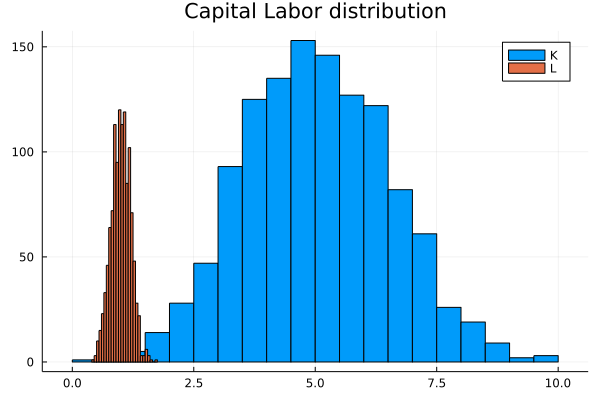

In [19]:
#Distribution for our agents
na=1200
#Distribution K,L primary good
K_d=Normal(5.0,1.5)
K_d = truncated(K_d, 0.2, Inf)

L_d=Normal(1.0,0.2)

k_p, l_p= rand(K_d, na), rand(L_d, na)

kl_dist=histogram([k_p l_p], label=["K" "L"], title="Capital Labor distribution")
savefig(kl_dist, "kl_dist.png") # save the most recent fig as filename_string (such as "output.png")
kl_dist

In [20]:
# Production cost, Production and level of inputs (K,L)
r, w, Y_p, Y_n, Y_l, K, L = Production(k_p,l_p)

#Initial price level given
p=[3.0, 4.0, 4.5]

#for loops
ng=3        # number sector
na=1200     # number agents
nr=2        # number of revenue type capital and labor

#Vectors and matrixes to store
Prod=[]                 #Store production level
D=zeros(ng)             #NH Demand
Excess=zeros(ng)        #Excess from Demand - Production
pricepath=[]            #follow the pricepath
R=[k_p l_p]             # size na*nr Capital and labor distribution matrix

#iterations
tol=1e-2
iter=0
itershock=0
maxiter=800
step=0.001

#We are looking for a pricepath at the GE.
#First value for excess, 
#1. if D>P Price increases
#2. if D<P Price drops

#Production in each sector
Prod=push!(Prod, Y_p, Y_n, Y_l)

for j=1:ng
    D[j]=sum(NHUtility(R[i,:],[r,w], p)[j] for i=1:na)
end

Excess= D-Prod

#Iterate this process for 500 times or reach a level which prices for each good clear the market
for j =1:ng
    while iter<=maxiter && abs(Excess[j])>tol
        iter = iter + 1
        #store price path
        pricepath=push!(pricepath, [p[1], p[2], p[3]])

        for i=1:ng
            p[i]= p[i]+ step * Excess[i]
            D[i]= sum(NHUtility(R[j,:],[r,w], p)[i] for j=1:na)
        end

        Excess=D-Prod
    end
end

print("Equilibrium reached after $iter iterations at prices $p")
@show Prod,D, Excess, p

pricep=pricepath
p_p=[]
p_n=[]
p_l=[]
for i=1:length(pricep)
    p_p=push!(p_p, pricep[i][1])
    p_n=push!(p_n, pricep[i][2])
    p_l=push!(p_l, pricep[i][3])
end

plot([p_p p_n p_l], title="GE prices with $ng goods, $na agents", label=["Primary" "Normal" "Luxury"])

DomainError: DomainError with -2.220446049250313e-16:
Exponentiation yielding a complex result requires a complex argument.
Replace x^y with (x+0im)^y, Complex(x)^y, or similar.

In [21]:
shock=1/20
temp=Prod[1]*(1-shock)
Prod[1]=temp
Prod

3-element Vector{Any}:
 640.0197412730721
 750.8133927824
 907.0573106487741

In [22]:
shockpricepath=pricepath
initial_p=[p[1], p[2], p[3]]

#After shock initial excess
Excess= D-Prod

#Iterate this process for 800 times or reach a level which prices for each good clear the market
for j =1:ng
    while itershock<=maxiter && abs(Excess[j])>tol
        itershock = itershock + 1
        #store price path
        pricepath=push!(pricepath, [p[1], p[2], p[3]])

        for i=1:ng
            p[i]= p[i]+ step * Excess[i]
            D[i]= sum(NHUtility(R[j,:],[r,w], p)[i] for j=1:na)
        end

        Excess=D-Prod
    end
end

after_shock_p=p

print("Equilibrium reached after $itershock iterations at prices $after_shock_p")
@show Prod,D, Excess, p

pricep=shockpricepath

p_p=[]
p_n=[]
p_l=[]
for i=1:length(pricep)
    p_p=push!(p_p, pricep[i][1])
    p_n=push!(p_n, pricep[i][2])
    p_l=push!(p_l, pricep[i][3])
end

@show Prod,D, Excess
pge=plot([p_p p_n p_l], title="GE prices with $ng goods, $na agents", label=["Primary" "Normal" "Luxury"])
savefig(pge, "ge_revenueprices.png") # save the most recent fig as filename_string (such as "output.png")

pge

DomainError: DomainError with -2.220446049250313e-16:
Exponentiation yielding a complex result requires a complex argument.
Replace x^y with (x+0im)^y, Complex(x)^y, or similar.

In [23]:
initial_p, after_shock_p

([3.3987865892893443, 3.5931676831679553, 3.7101055124832345], [3.752341505149021, 3.4493922073339895, 3.6689583824994108])

In [24]:
A=[]
B=[]

Exp=[]
C_P=[]
C_N=[]
C_L=[]
U=[]
p_w=[r,w]
#Deciles
for j=1:10
    for i=1:na/10
        A=push!(A,Int(i))
        B=push!(B,Int(j))
    end
end

#Initial endowment with GE prices

for j = 1:na
    E=sum(p_w[i]*R[j,i] for i = 1:nr)
    C1=NHUtility(R[j,:],[r,w], initial_p)[1]
    C2=NHUtility(R[j,:],[r,w], initial_p)[2]
    C3=NHUtility(R[j,:],[r,w], initial_p)[3]
    Utility=NHUtility(R[j,:],[r,w], initial_p)[4]

    
    Exp=push!(Exp,E)
    C_P=push!(C_P,C1)
    C_N=push!(C_N,C2)
    C_L=push!(C_L,C3)
    U=push!(U,Utility)
end

initial= [A U R Exp C_P C_N C_L]
initial=sortslices(initial,dims=1,by=x->(x[5]),rev=false)


#After the shock, endowment with GE prices
C_P=[]
C_N=[]
C_L=[]
U=[]
Exp_ng=[]
for j = 1:na
    E=sum(p_w[i]*R[j,i] for i = 1:nr)
    C1=NHUtility(R[j,:],[r,w], after_shock_p)[1]
    C2=NHUtility(R[j,:],[r,w], after_shock_p)[2]
    C3=NHUtility(R[j,:],[r,w], after_shock_p)[3]
    Utility=NHUtility(R[j,:],[r,w], after_shock_p)[4]

    
    Exp_ng=push!(Exp_ng,E)
    C_P=push!(C_P,C1)
    C_N=push!(C_N,C2)
    C_L=push!(C_L,C3)
    U=push!(U,Utility)
end

after_shock=[A U R Exp_ng C_P C_N C_L]
after_shock=sortslices(after_shock,dims=1,by=x->(x[5]),rev=false)

DomainError: DomainError with -2.220446049250313e-16:
Exponentiation yielding a complex result requires a complex argument.
Replace x^y with (x+0im)^y, Complex(x)^y, or similar.

In [25]:
initial_p, after_shock_p

([3.3987865892893443, 3.5931676831679553, 3.7101055124832345], [3.752341505149021, 3.4493922073339895, 3.6689583824994108])

In [26]:
loss=(initial-after_shock)./initial

1200×8 Matrix{Float64}:
 0.0  0.0436326  0.0  0.0  0.0  0.0526759   0.00472954   0.00789344
 0.0  0.042079   0.0  0.0  0.0  0.0524452   0.00432559   0.00722895
 0.0  0.0409305  0.0  0.0  0.0  0.0522749   0.00402728   0.00673814
 0.0  0.0406825  0.0  0.0  0.0  0.0522381   0.00396292   0.00663222
 0.0  0.0398696  0.0  0.0  0.0  0.0521177   0.00375196   0.00628505
 0.0  0.0395862  0.0  0.0  0.0  0.0520758   0.00367847   0.00616409
 0.0  0.039547   0.0  0.0  0.0  0.0520699   0.0036683    0.00614736
 0.0  0.0392726  0.0  0.0  0.0  0.0520293   0.00359713   0.00603022
 0.0  0.0391314  0.0  0.0  0.0  0.0520084   0.00356053   0.00596997
 0.0  0.0383949  0.0  0.0  0.0  0.0518995   0.00336965   0.00565576
 ⋮                              ⋮                       
 0.0  0.0189149  0.0  0.0  0.0  0.049043   -0.00163985  -0.00260441
 0.0  0.018717   0.0  0.0  0.0  0.0490142  -0.00169036  -0.00268783
 0.0  0.0185627  0.0  0.0  0.0  0.0489918  -0.00172972  -0.00275285
 0.0  0.0185519  0.0  0.0  0.0  0.0

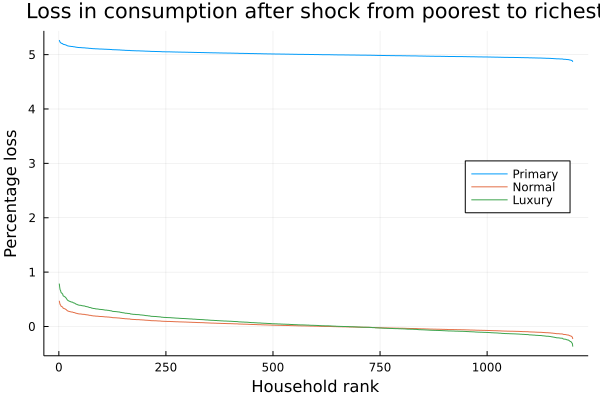

In [27]:
cons_loss=loss[:,[6,7,8]]
pcons=plot(1:na, cons_loss*100, title="Loss in consumption after shock from poorest to richest", xlabel="Household rank", ylabel="Percentage loss", label=["Primary" "Normal" "Luxury"], legend=:right)

savefig(pcons, "consLoss.png") # save the most recent fig as filename_string (such as "output.png")
pcons

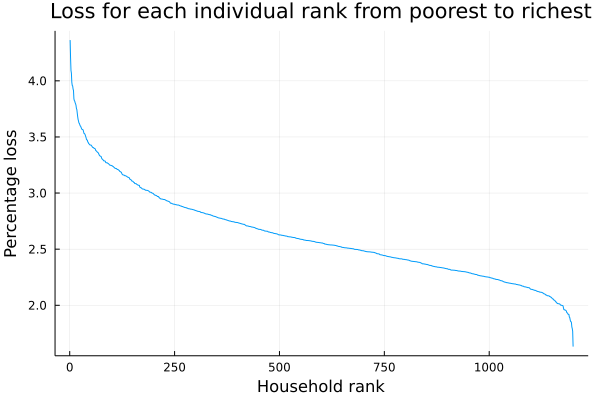

In [28]:
Utility_loss=loss[:,2]
p_utils=plot(1:na, Utility_loss*100, title="Loss for each individual rank from poorest to richest", xlabel="Household rank", ylabel="Percentage loss", legend=false)
savefig(p_utils, "utilityloss_revenue.png") # save the most recent fig as filename_string (such as "output.png")
p_utils

In [29]:
C1=[]
C2=[]
C3=[]
U=[]
for i=LinRange(0.2,1,1000)
    for j=LinRange(0.2,1,1000)
            res=NHUtility([i,j], p_w0, p_c0)
            C1=push!(C1, res[1])
            C2=push!(C2, res[2])
            C3=push!(C3, res[3])
            U=push!(U, res[4])
    end
end

demand=[C1 C2 C3 U]
demand=sortslices(demand,dims=1,by=x->(x[4]),rev=false)

X=demand[:,[1,2,3]]
plot(demand[:,4],X)

UndefVarError: UndefVarError: p_w0 not defined

## Environment

In this example, prices were first given at p=[r0, w0].

However, this price level does not clear the market, we have demand that takes over endowment level in our economy. Hence we update the price level such that non homothetic is exactly equal to the endowment level.

We set 3 sectors with 300 agents.

### Random endowments

- Lognormal for luxury products
- Normal distribution for Primary and Normal, higher quantity for primary quantity

In terms of aggregate quantity : $ Q_P>Q_N>Q_L$

In [59]:
# Aiyagari model
# Endogenous Grid Points with IID Income
# Greg Kaplan 2017
# Translated by Tom Sweeney Jan 2021

using Random, Interpolations,NLsolve, Plots

# PARAMETERS

## preferences
risk_aver = 2
beta = 0.95

## production
deprec = 0.10
capshare = 0.4

## income risk: discretized N(mu,sigma^2)
mu_y = 1
sd_y = 0.2
ny = 5

## asset grids
na = 40
amax = 50
borrow_lim = 0
agrid_par = 1.0 # 1 for linear, 0 for L-shaped

## computation
max_iter = 1000
tol_iter = 1.0e-6
Nsim = 50000
Tsim = 500

maxiter_KL = 70
tol_KL = 1.0e-5
step_KL = 0.005
rguess = 1/beta-1-0.001 # a bit lower than inverse of discount rate
KLratioguess = ((rguess + deprec)/capshare)^(1/(capshare-1))

# OPTIONS
Display = 1
MakePlots = 1

## which function to interpolation 
InterpCon = 0
InterpEMUC = 1

## tolerance for non-linear solver
TolX=1.0e-6

# UTILITY FUNCTION

if risk_aver==1
    u(c) = log.(c)
else
    u(c) = (c.^(1-risk_aver).-1)./(1-risk_aver)
end 

u1(c) = c.^(-risk_aver)
u1inv(u) = u.^(-1 ./risk_aver)

# SET UP GRIDS

## assets
agrid = range(0,1,length=na)
agrid = agrid.^(1 ./ agrid_par)
agrid = borrow_lim .+ (amax.-borrow_lim).*agrid

histogram(agrid)
ycumdist = cumsum(ydist)

yrand = rand(Nsim,Tsim)

if Display>=1
    println("Simulating labor efficiency realizations in advance")
end
yindsim = zeros(Int,Nsim,Tsim)
    
for it = 1:Tsim

    # income realization: note we vectorize simulations at once because
    # of matlab, in other languages we would loop over individuals
    yindsim[yrand[:,it].<=ycumdist[1],it] .= 1
    for iy = 2:ny
        yindsim[(yrand[:,it].>ycumdist[iy-1]) .& (yrand[:,it].<=ycumdist[iy]),it] .= iy;
    end
end
    
ysim = ygrid[yindsim]

UndefVarError: UndefVarError: ydist not defined

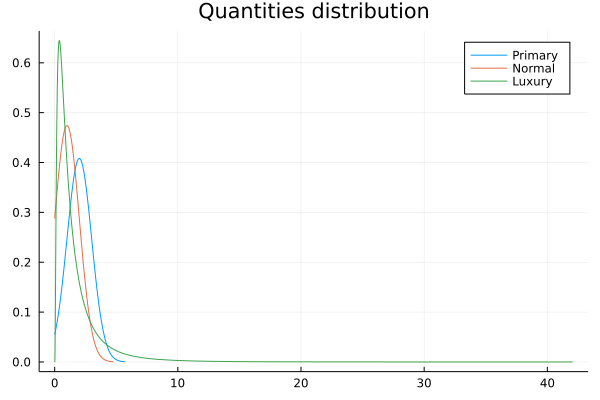

In [55]:
#Economy size
ng=3        #number of sector
na=300   #number of people
p_m=[5.0, 8.0]
p=[4.0, 5.0, 10.0]

#Good matrix
G=zeros(na,ng)

#Quantities distribution for each person
D_P=Normal(2,1)
D_P = truncated(D_P, 0.0, Inf)
D_N=Normal(1,1)
D_N = truncated(D_N, 0.0, Inf)
D_L=LogNormal(0.02,1)
D_L = truncated(D_L, 0.0, Inf)


qdist=plot(D_P, title="Quantities distribution", label="Primary")
plot!(D_N, label="Normal")
plot!(D_L, label="Luxury")

savefig(qdist, "q_dist.png") # save the most recent fig as filename_string (such as "output.png")
qdist

(W, D, Excess, p) = ([610.2877473127617, 394.04554299190187, 534.0369807060141], [610.2877476323899, 394.04555264967945, 534.0369738356103], [3.1962827051756904e-7, 9.657777582106064e-6, -6.87040380853432e-6], [1.6398995594754044, 6.911106365185391, 9.816684799071519])


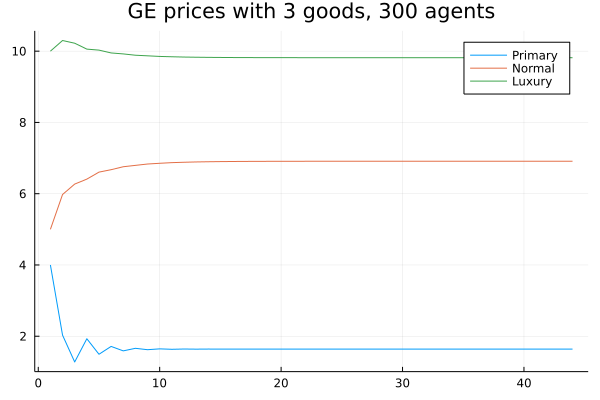

In [59]:
#Initial price level given
p=[4.0, 5.0, 10.0]

#leading to a Expenditure vector evaluated by a distribution of good
Exp=[]

for j=1:na
    G[j,1]=rand(D_P)
    G[j,2]=rand(D_N)
    G[j,3]=rand(D_L)
end

#Vectors and matrixes to store
W=zeros(ng)             #Endowment
D=zeros(ng)             #NH Demand
Excess=zeros(ng)
pricepath=[]

#iterations
tol=1e-5
iter=0
maxiter=500

#We are looking for a pricepath at the GE.
#First value for excess, 
#1. if D>W Price increases
#2. if D<W Price drops
for i=1:ng
    W[i]=sum(G[j,i] for j=1:na)
    D[i]=sum(NHUtility(G[j,:],p)[i] for j=1:na)
end

Excess=D-W

for j =1:ng
    while iter<=maxiter && abs(Excess[j])>tol
        iter = iter + 1
        pricepath=push!(pricepath, [p[1], p[2], p[3]])
        for i=1:ng
            p[i]=p[i]+0.01*Excess[i]
            W[i]=sum(G[j,i] for j=1:na)
            D[i]=sum(NHUtility(G[j,:],p)[i] for j=1:na)        
        end
        Excess=D-W
    end
end

@show W,D, Excess, p

pricep=pricepath
p_p=[]
p_n=[]
p_l=[]
for i=1:length(pricep)
    p_p=push!(p_p, pricep[i][1])
    p_n=push!(p_n, pricep[i][2])
    p_l=push!(p_l, pricep[i][3])
end

plot([p_p p_n p_l], title="GE prices with $ng goods, $na agents", label=["Primary" "Normal" "Luxury"])

Suppose we know design a supply shock where a fifth of the Primary good aggregate quantity destroyed.

In [60]:
initial_p=p
Exp=[]
for a = 1:Int(length(G)/ng)
    E=sum(initial_p[i]*G[a,i] for i = 1:ng)
    Exp=push!(Exp,E)
end

initial=[G Exp]
initial=sortslices(initial,dims=1,by=x->(x[4]),rev=false)
G=convert(Matrix{Float64},initial[:,[1,2,3]])

#after shock endowment level
n_G=copy(G)
s_shock=1/5
n_G[:,1]=G[:,1].*(1-s_shock)
n_G

300×3 Matrix{Float64}:
 0.608417   0.249798    0.214027
 0.0429358  0.541211    0.193633
 1.15162    0.039115    0.370626
 1.97125    0.20738     0.120871
 1.7816     0.0763092   0.275626
 1.68407    0.372144    0.0933756
 1.47931    0.0678159   0.368226
 0.349915   0.725124    0.18295
 1.05537    0.113794    0.479967
 2.44783    0.130022    0.180086
 ⋮                     
 1.67971    2.19016     6.03783
 1.8555     1.87887     6.8689
 2.67455    0.953956    7.76368
 1.09931    0.628617    9.67925
 3.05984    1.22197     9.08167
 0.560538   2.4267      8.78253
 0.793385   0.668696   11.1717
 1.13819    1.22452    15.3388
 1.59197    0.598554   29.5886

Then continue to look for equilibrium at GE prices to find another GE with supply shock.

(W, D, Excess) = ([488.2301978502094, 394.0455429919017, 534.0369807060143], [488.2301983421288, 394.04555076800364, 534.0369750946102], [4.919194225294632e-7, 7.776101938361535e-6, -5.6114041626642575e-6])


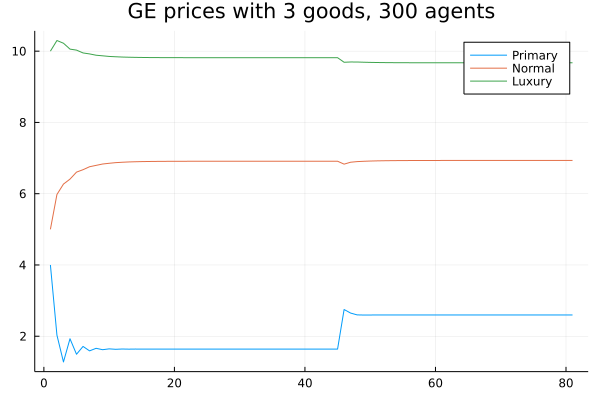

In [61]:
shockpricepath=pricepath
initial_p=[p[1], p[2], p[3]]

#After shock initial excess
for i=1:ng
    W[i]=sum(n_G[j,i] for j=1:na)
    D[i]=sum(NHUtility(n_G[j,:],p)[i] for j=1:na)
end

Excess=D-W

iter_shock=0

for j =1:ng
    while iter_shock<=maxiter && abs(Excess[j])>tol
        iter_shock = iter_shock + 1
        shockpricepath=push!(shockpricepath, [p[1], p[2], p[3]])
        for i=1:ng
            p[i]=p[i]+0.01*Excess[i]
            W[i]=sum(n_G[j,i] for j=1:na)
            D[i]=sum(NHUtility(n_G[j,:],p)[i] for j=1:na)        
        end
    Excess=D-W
    end
end

after_shock_p=p
pricep=shockpricepath

p_p=[]
p_n=[]
p_l=[]
for i=1:length(pricep)
    p_p=push!(p_p, pricep[i][1])
    p_n=push!(p_n, pricep[i][2])
    p_l=push!(p_l, pricep[i][3])
end

@show W,D, Excess
pge=plot([p_p p_n p_l], title="GE prices with $ng goods, $na agents", label=["Primary" "Normal" "Luxury"])
savefig(pge, "ge_prices.png") # save the most recent fig as filename_string (such as "output.png")

pge

In [62]:
initial_p, after_shock_p,p

([1.6398995594754044, 6.911106365185391, 9.816684799071519], [2.5972309291717197, 6.933023816532573, 9.673787618512863], [2.5972309291717197, 6.933023816532573, 9.673787618512863])

In [63]:
A=[]
B=[]

Exp=[]
C_P=[]
C_N=[]
C_L=[]
U=[]
#Deciles
for j=1:10
    for i=1:na/10
        A=push!(A,Int(i))
        B=push!(B,Int(j))
    end
end

#Initial endowment with GE prices

for a = 1:Int(length(G)/ng)
    E=sum(initial_p[i]*G[a,i] for i = 1:ng)
    C1=NHUtility(G[a,:],initial_p)[1]
    C2=NHUtility(G[a,:],initial_p)[2]
    C3=NHUtility(G[a,:],initial_p)[3]
    Utility=NHUtility(G[a,:],initial_p)[4]

    
    Exp=push!(Exp,E)
    C_P=push!(C_P,C1)
    C_N=push!(C_N,C2)
    C_L=push!(C_L,C3)
    U=push!(U,Utility)
end
#initial=sortslices(initial,dims=1,by=x->(x[1]),rev=false)

initial= [A U G Exp C_P C_N C_L]

300×9 Matrix{Any}:
  1    0.87288  0.760521   0.249798   …   0.574532  0.276086   0.22659
  2    1.06586  0.0536698  0.541211       0.629032  0.308374   0.261439
  3    1.23515  1.43952    0.039115       0.672725  0.334691   0.29063
  4    1.3632   2.46406    0.20738        0.703737  0.353591   0.312003
  5    1.43868  2.22701    0.0763092      0.721311  0.364379   0.32435
  6    1.45755  2.10509    0.372144   …   0.72563   0.367039   0.327411
  7    1.51767  1.84914    0.0678159      0.739197  0.375416   0.33709
  8    1.66124  0.437394   0.725124       0.77051   0.394872   0.359805
  9    1.7103   1.31921    0.113794       0.780886  0.401356   0.367447
 10    1.71848  3.05979    0.130022       0.782602  0.40243    0.368717
  ⋮                                   ⋱                       
 22   58.8631   2.09964    2.19016        4.23232   3.09883    5.04184
 23   65.9691   2.31938    1.87887        4.4779    3.31622    5.49639
 24   70.6302   3.34319    0.953956       4.63204   3.45387 

In [64]:
#After the shock, endowment with GE prices
C_P=[]
C_N=[]
C_L=[]
U=[]
Exp_ng=[]
for a = 1:Int(length(n_G)/ng)
    E=sum(initial_p[i]*n_G[a,i] for i = 1:ng)
    C1=NHUtility(n_G[a,:],initial_p)[1]
    C2=NHUtility(n_G[a,:],initial_p)[2]
    C3=NHUtility(n_G[a,:],initial_p)[3]
    Utility=NHUtility(n_G[a,:],initial_p)[4]

    Exp_ng=push!(Exp_ng,E)
    C_P=push!(C_P,C1)
    C_N=push!(C_N,C2)
    C_L=push!(C_L,C3)
    U=push!(U,Utility)
end
after_shock=[A U n_G Exp_ng C_P C_N C_L]

300×9 Matrix{Any}:
  1    0.803044  0.608417   0.249798   …   0.55327   0.263661   0.21348
  2    1.06049   0.0429358  0.541211       0.62759   0.307512   0.260494
  3    1.08667   1.15162    0.039115       0.63459   0.311701   0.265091
  4    1.1037    1.97125    0.20738        0.639096  0.314402   0.268065
  5    1.19851   1.7816     0.0763092      0.663548  0.329133   0.284408
  6    1.22903   1.68407    0.372144   …   0.671203  0.333768   0.289594
  7    1.31318   1.47931    0.0678159      0.691812  0.346303   0.303721
  8    1.61034   0.349915   0.725124       0.759576  0.388059   0.351814
  9    1.55689   1.05537    0.113794       0.747899  0.380806   0.34335
 10    1.36988   2.44783    0.130022       0.705313  0.354556   0.313103
  ⋮                                    ⋱                       
 22   58.1086    1.67971    2.19016        4.20542   3.07516    4.99285
 23   65.1081    1.8555     1.87887        4.44886   3.29039    5.44194
 24   69.3658    2.67455    0.953956       4.

In [65]:
loss=(initial-after_shock)./initial

300×9 Matrix{Float64}:
 0.0  0.0800062   0.2  0.0  0.0  …  0.0370076   0.0450044   0.0578579
 0.0  0.00503574  0.2  0.0  0.0     0.00229321  0.00279678  0.00361452
 0.0  0.120208    0.2  0.0  0.0     0.056688    0.0686919   0.0878735
 0.0  0.19036     0.2  0.0  0.0     0.0918545   0.11083     0.140824
 0.0  0.166936    0.2  0.0  0.0     0.0800803   0.0967296   0.123145
 0.0  0.156786    0.2  0.0  0.0  …  0.0750067   0.0906473   0.115501
 0.0  0.134738    0.2  0.0  0.0     0.0641028   0.0775498   0.0989905
 0.0  0.0306356   0.2  0.0  0.0     0.01419     0.0172526   0.022209
 0.0  0.0896927   0.2  0.0  0.0     0.0422433   0.0512015   0.0655802
 0.0  0.202854    0.2  0.0  0.0     0.0987594   0.118962    0.15083
 ⋮                               ⋱                          
 0.0  0.0128186   0.2  0.0  0.0     0.00635739  0.00763851  0.00971681
 0.0  0.0130516   0.2  0.0  0.0     0.0064863   0.00779067  0.00990662
 0.0  0.0179024   0.2  0.0  0.0     0.00891827  0.010707    0.0136068
 0.0  0.0

In [66]:
Utility_loss=loss[:,2]

300-element Vector{Float64}:
 0.08000624394642138
 0.005035740497941102
 0.12020823526199682
 0.19036030967704545
 0.16693587665625684
 0.1567857235497128
 0.13473823064122778
 0.030635647582718587
 0.08969265506573502
 0.20285358099106554
 ⋮
 0.012818600952473344
 0.013051565749934515
 0.017902378148722545
 0.006371898082571795
 0.017310845164005963
 0.0031691222188029657
 0.004014311836802942
 0.004091548233462195
 0.003043864118865116

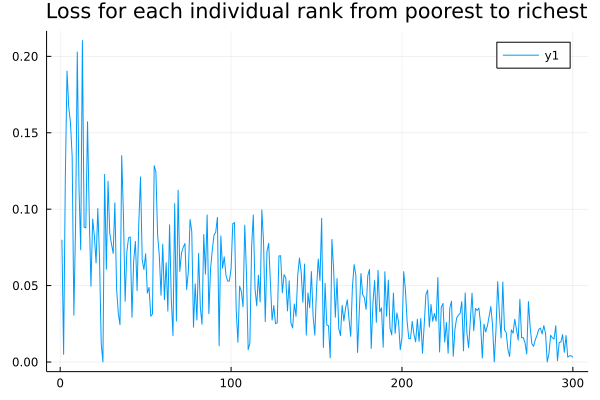

In [67]:
p1=plot(Utility_loss, title="Loss for each individual rank from poorest to richest")
savefig(p1, "Utility_loss.png") # save the most recent fig as filename_string (such as "output.png")
p1

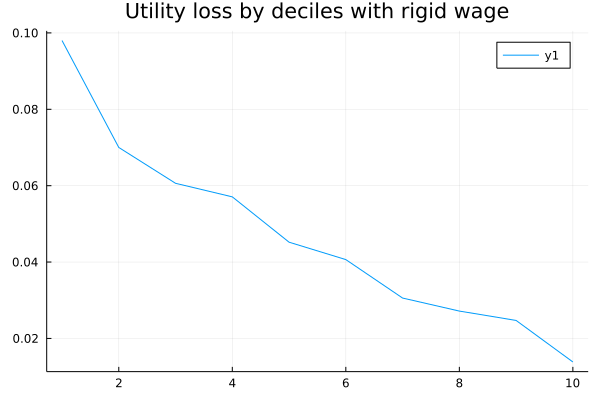

In [68]:
na=30
decile=10
dec=reshape(Utility_loss,(na,decile))
dec=mean(dec,dims=1)
dec=transpose(dec)

p2=plot(dec, title="Utility loss by deciles with rigid wage")
savefig(p2, "Utility_loss_deciles.png") # save the most recent fig as filename_string (such as "output.png")
p2